(scrna_seq_workflow)=

## Precaching normalized values for faster gene query and marker search

This workflow shows how to use `save_normed_for_query` function to create a cache of genes. This cache substantially improves the runtime of `run_marker_search` and also when querying for multiple genes. The precaching is a one time process for a dataset and can speed up all subsequent marker search steps.

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.23.0'

time: 1.52 s (started: 2022-09-12 02:10:33 +02:00)


In [2]:
scarf.fetch_dataset(
    'zheng_69K_pbmc_rnaseq',
    save_path='scarf_datasets'
)

time: 21.8 s (started: 2022-09-11 13:07:14 +02:00)


In [3]:
reader = scarf.CrDirReader('scarf_datasets/zheng_69K_pbmc_rnaseq')
writer = scarf.CrToZarr(
    reader,
    zarr_fn='scarf_datasets/zheng_69K_pbmc_rnaseq/data.zarr',
    chunk_size=(1000, 1000)
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 31.7 s (started: 2022-09-11 13:07:36 +02:00)


(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

INFO: 2311 cells flagged for filtering out using attribute RNA_nCounts
INFO: 2435 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 1391 cells flagged for filtering out using attribute RNA_percentMito
INFO: 2678 cells flagged for filtering out using attribute RNA_percentRibo


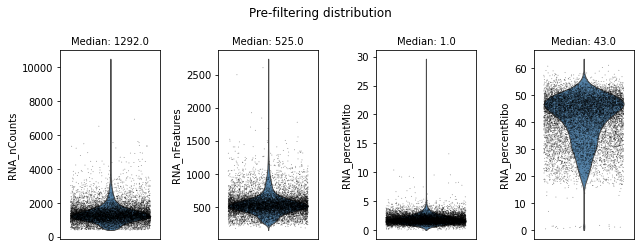

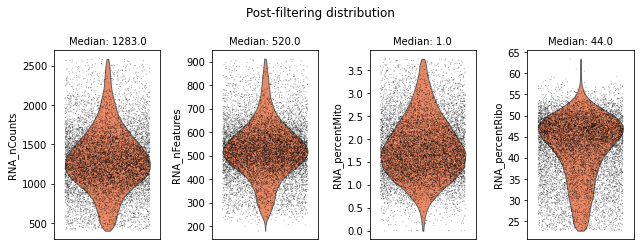

(RNA) Computing nCells:   0%|                                                                                 …

(RNA) Computing normed_tot:   0%|                                                                             …

(RNA) Computing sigmas:   0%|                                                                                 …

INFO: 500 genes marked as HVGs


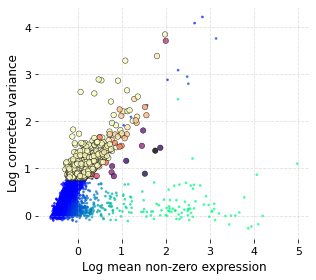

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__hvgs/data:   0%|                                                                   …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.20%
time: 2min 33s (started: 2022-09-11 13:08:07 +02:00)


In [4]:
ds = scarf.DataStore(
    'scarf_datasets/zheng_69K_pbmc_rnaseq/data.zarr',
    nthreads=4,
    min_features_per_cell=10
)
ds.auto_filter_cells()
ds.mark_hvgs(
    min_cells=20,
    top_n=500,
    min_mean=-3,
    max_mean=2,
    max_var=6
)
ds.make_graph(
    feat_key='hvgs',
    k=11,
    dims=15
)
ds.run_leiden_clustering(resolution=0.5)

In [3]:
ds.show_zarr_tree()

/
 ├── RNA
 │   ├── counts (68579, 32738) uint32
 │   ├── featureData
 │   ├── markers
 │   ├── normed__I__hvgs
 │   ├── prenormed
 │   └── summary_stats_I
 └── cellData
     ├── I (68579,) bool
     ├── RNA_leiden_cluster (68579,) int32
     ├── RNA_nCounts (68579,) float64
     ├── RNA_nFeatures (68579,) float64
     ├── RNA_percentMito (68579,) float64
     ├── RNA_percentRibo (68579,) float64
     ├── ids (68579,) <U16
     └── names (68579,) <U16
time: 32 ms (started: 2022-09-12 02:04:32 +02:00)


In [5]:
ds.run_marker_search(
    group_key='RNA_leiden_cluster',
)

Finding markers:   0%|                                                                                        …

Aggregating results:   0%|                                                                                    …

time: 11min 11s (started: 2022-09-11 13:10:41 +02:00)


In [7]:
import numpy as np

time: 0 ns (started: 2022-09-12 02:07:44 +02:00)


In [14]:
assay = ds.RNA
cell_key = "I"
group_key = "RNA_leiden_cluster"
topn = 3
slot_name = f"{cell_key}__{group_key}"
g = assay.z["markers"][slot_name]
feat_idx = []
for i in g.keys():
    if "feature_index" in g[i]:
        feat_idx.extend(g[i]["feature_index"][:][:topn])
feat_idx = np.array(sorted(set(feat_idx)))
feat_idx

array([10298, 10448, 10479, 10780, 11062,  1252, 12534, 13131, 13252,
       13508,  1426, 14315, 14585, 15343, 15576, 16569, 16683, 16737,
       16744,  1738, 17720, 18148, 18926, 18941, 18944, 18964, 19161,
       19404, 19527,  1957, 19922,  2067, 20738, 20918, 21053, 21112,
       21196, 21418, 22144,  2242, 22421, 22588, 23450, 23926,  2482,
       24889,  2493, 25899, 26085, 27057, 27068, 27379, 27507,  2757,
       27762, 27949, 28145, 28832, 28952, 29328, 29417, 29706, 29741,
       29952, 30711, 31189, 31550, 31698, 31909,  3198, 32134,   469,
         486,  4864,   493,  5096,    52,  5871,  7223,  7344,  7696,
        7755,  8156,  8886,  8889,  9600])

time: 109 ms (started: 2022-09-12 02:09:31 +02:00)


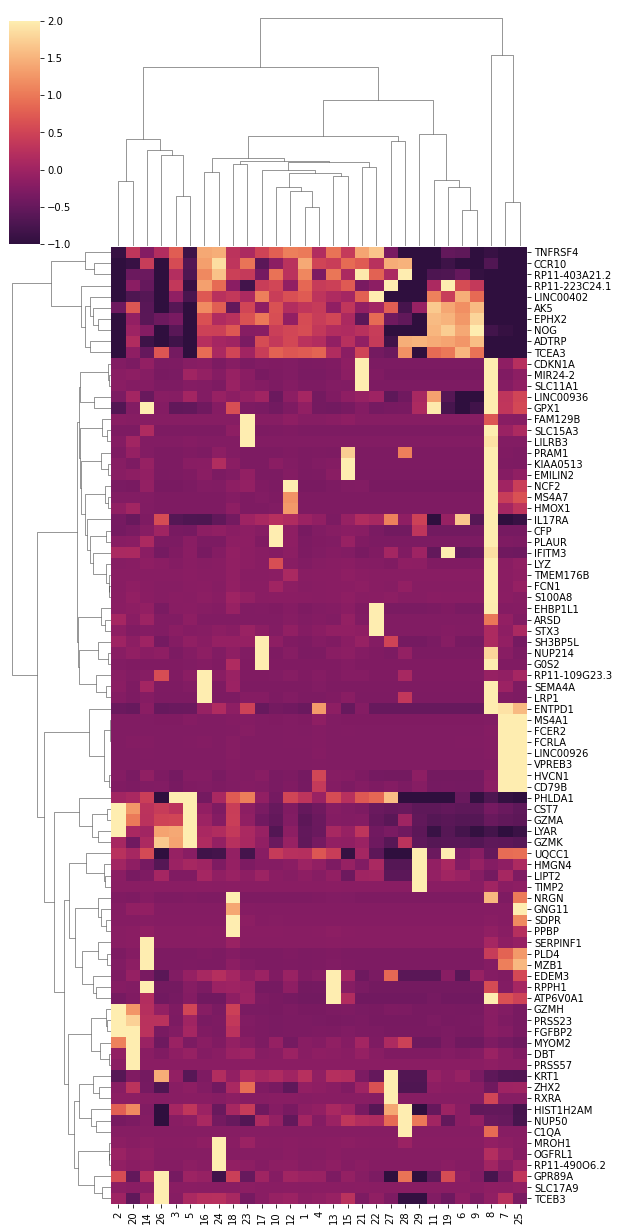

time: 8.86 s (started: 2022-09-12 02:10:42 +02:00)


In [3]:
ds.plot_marker_heatmap(group_key="RNA_leiden_cluster", topn=3)

### Pre-caching normalized expression for fast query

In [2]:
ds = scarf.DataStore(
    'scarf_datasets/zheng_69K_pbmc_rnaseq/data.zarr',
    nthreads=4,
)

time: 62 ms (started: 2022-09-12 02:10:38 +02:00)


In [ ]:
scarf.DataStore()

In [3]:
ds.RNA.save_normed_for_query('I', batch_size=100)

Saving features:   0%|                                                                                        …

time: 2min 21s (started: 2022-09-11 17:23:15 +02:00)


In [7]:
ds.RNA.save_normed_for_query('I', batch_size=100)

Saving features:   0%|                                                                                        …

time: 3min 12s (started: 2022-09-11 13:22:02 +02:00)


In [ ]:
ds.RNA.save_normalized_data()

### Marker search with precached data

In [8]:
ds.run_marker_search(
    group_key='RNA_leiden_cluster',
    use_prenormed=True
)

Finding markers:   0%|                                                                                        …

Aggregating results:   0%|                                                                                    …

time: 2min 16s (started: 2022-09-11 13:25:14 +02:00)


### The marker search is almost 500% faster with precaching

In [13]:
ds.get_markers(group_key="RNA_leiden_cluster")

,group_id,feature_name,feature_index,score,mean,mean_rest,frac_exp,frac_exp_rest,fold_change
0,2,GZMH,22588,0.53664,1.97866,0.04272,0.72856,0.02577,46.31955
1,2,FGFBP2,7344,0.5185,1.56343,0.03036,0.68939,0.01948,51.49853
2,2,PRSS23,19527,0.47935,0.25454,0.00469,0.2236,0.00493,54.22205
3,2,CCL4,26839,0.42904,0.52845,0.02215,0.38225,0.01945,23.85314
4,2,GZMB,22589,0.42316,2.44447,0.07253,0.81338,0.0273,33.70516
...,...,...,...,...,...,...,...,...,...
134,25,FAM26F,11346,0.2531,0.3855,0.04988,0.36154,0.04726,7.72825
135,26,SLC17A9,29328,0.63995,0.75179,0.00145,1.0,0.00129,517.76876
136,27,RXRA,16737,0.70412,0.76149,0.00806,0.94737,0.00624,94.5346
137,28,C1QA,469,0.59261,0.59869,0.0102,0.8,0.00454,58.69361


time: 9.86 s (started: 2022-09-11 16:17:07 +02:00)


In [24]:
ds.RNA.nthreads

4

time: 0 ns (started: 2022-09-11 17:17:48 +02:00)


In [22]:
for i in ds.RNA.normed()[:100].compute():
    print (i.shape)
    break

(13523,)
time: 187 ms (started: 2022-09-11 17:15:48 +02:00)


In [17]:
ds.get_markers(group_key="RNA_leiden_cluster", group_id='2')

,group_id,feature_name,feature_index,score,mean,mean_rest,frac_exp,frac_exp_rest,fold_change
0,2,GZMH,22588,0.53664,1.97866,0.04272,0.72856,0.02577,46.31955
1,2,FGFBP2,7344,0.5185,1.56343,0.03036,0.68939,0.01948,51.49853
2,2,PRSS23,19527,0.47935,0.25454,0.00469,0.2236,0.00493,54.22205
3,2,CCL4,26839,0.42904,0.52845,0.02215,0.38225,0.01945,23.85314
4,2,GZMB,22589,0.42316,2.44447,0.07253,0.81338,0.0273,33.70516
5,2,GNLY,4046,0.39703,12.16159,0.45893,0.97065,0.11858,26.49974
6,2,FCGR3A,2237,0.39447,0.63592,0.03002,0.44823,0.02172,21.18457
7,2,SPON2,7169,0.38924,0.484,0.01926,0.33245,0.01974,25.12479
8,2,PRF1,17449,0.36165,0.96429,0.04765,0.58227,0.04604,20.23739
9,2,KLRD1,20269,0.35642,0.24462,0.01417,0.22163,0.01454,17.26285


time: 328 ms (started: 2022-09-11 16:18:13 +02:00)


In [15]:
ds.show_zarr_tree(start='RNA/markers')

markers
 └── I__RNA_leiden_cluster
     ├── 1
     ├── 10
     ├── 11
     ├── 12
     ├── 13
     ├── 14
     ├── 15
     ├── 16
     ├── 17
     ├── 18
     ├── 19
     ├── 2
     ├── 20
     ├── 21
     ├── 22
     ├── 23
     ├── 24
     ├── 25
     ├── 26
     ├── 27
     ├── 28
     ├── 29
     ├── 3
     ├── 4
     ├── 5
     ├── 6
     ├── 7
     ├── 8
     └── 9
time: 31 ms (started: 2022-09-11 16:17:34 +02:00)


In [9]:
ds.plot_marker_heatmap(group_key="RNA_leiden_cluster", topn=3)

TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'int'

time: 2.7 s (started: 2022-09-11 13:27:31 +02:00)


The heatmaps clearly show that the marker search performed with and without `use_prenormed` parameter lead to same output

---
That is all for this vignette.